# **A Novel Approach for Three-Way Classification of Lumbar Spine Degeneration Using Pseudo-Modality Learning to Handle Missing MRI Data**

## **Embeddings Architecture**

![MRI Processor Architecture](https://github.com/ahmedembeddedxx/lumbar-spine-degenerative-classification/blob/main/architecture/classifiers-architecture/mri-processor.png?raw=true)


## **Modules**

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

#### **Embeddings Generator using ResNet50**

In [2]:
def generate_embeddings(dir_name, csv_path, study_path):
    os.makedirs(dir_name, exist_ok=True)

    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    df = pd.read_csv(csv_path)
    results = []

    for index, row in tqdm(df.iterrows()):
        patient_id = str(row['study_id'])
        series_id = str(row['series_id'])
        series_path = os.path.join(study_path, patient_id, series_id)
        embeddings = []

        for slice_file in os.listdir(series_path):
            if slice_file.endswith('.npy'):
                slice_path = os.path.join(series_path, slice_file)
                slice_data = np.load(slice_path)

                if slice_data.ndim == 2:
                    slice_data = np.stack([slice_data] * 3, axis=0)
                elif slice_data.ndim == 3 and slice_data.shape[0] == 1:
                    slice_data = np.repeat(slice_data, 3, axis=0)

                input_tensor = torch.from_numpy(slice_data).float()
                input_tensor = transforms.Resize((224, 224))(input_tensor)
                input_tensor = (input_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)) / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                input_tensor = input_tensor.unsqueeze(0)

                with torch.no_grad():
                    embedding = model(input_tensor).view(-1)
                    embeddings.append(embedding.numpy())

        if embeddings:
            average_embedding = np.mean(np.vstack(embeddings), axis=0)
            embedding_dict = {f'{i}': average_embedding[i] for i in range(512)}
            embedding_dict.update({'study_id': patient_id, 'series_id': series_id})
            results.append(embedding_dict)

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{dir_name}/final_embeddings.csv', index=False)
    torch.save(model.state_dict(), f'{dir_name}/model_embeddings.pth')

## **Running Inference**

In [ ]:
generate_embeddings(
    dir_name='at2-greyscl', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_AT2.csv', 
    study_path='/kaggle/input/preprocessed-dataset/grey_scale_train'
)

generate_embeddings(
    dir_name='at2-hist', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_AT2.csv', 
    study_path='/kaggle/input/preprocessed-dataset/hist_norm_train'
)

generate_embeddings(
    dir_name='st2-greyscl', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_ST2.csv', 
    study_path='/kaggle/input/preprocessed-dataset/grey_scale_train'
)

generate_embeddings(
    dir_name='st2-hist', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_ST2.csv', 
    study_path='/kaggle/input/preprocessed-dataset/hist_norm_train'
)

generate_embeddings(
    dir_name='st1-greyscl', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_ST1.csv', 
    study_path='/kaggle/input/preprocessed-dataset/grey_scale_train'
)

generate_embeddings(
    dir_name='st1-hist', 
    csv_path='/kaggle/input/preprocessed-dataset/train_data_ST1.csv', 
    study_path='/kaggle/input/preprocessed-dataset/hist_norm_train'
)


2226it [43:50,  1.18s/it]


Embeddings with attention completed and saved to AT2_attention_embeddings_gsl.csv


2226it [43:54,  1.18s/it]


Embeddings with attention completed and saved to AT2_attention_embeddings_hist.csv


1876it [18:31,  1.69it/s]


Embeddings with attention completed and saved to ST2_attention_embeddings_gsl.csv


1876it [18:33,  1.68it/s]


Embeddings with attention completed and saved to ST2_attention_embeddings_hist.csv


1881it [19:11,  1.63it/s]


Embeddings with attention completed and saved to ST1_attention_embeddings_gsl.csv


1881it [18:52,  1.66it/s]


Embeddings with attention completed and saved to ST1_attention_embeddings_hist.csv


## **Plotting Embeddings**

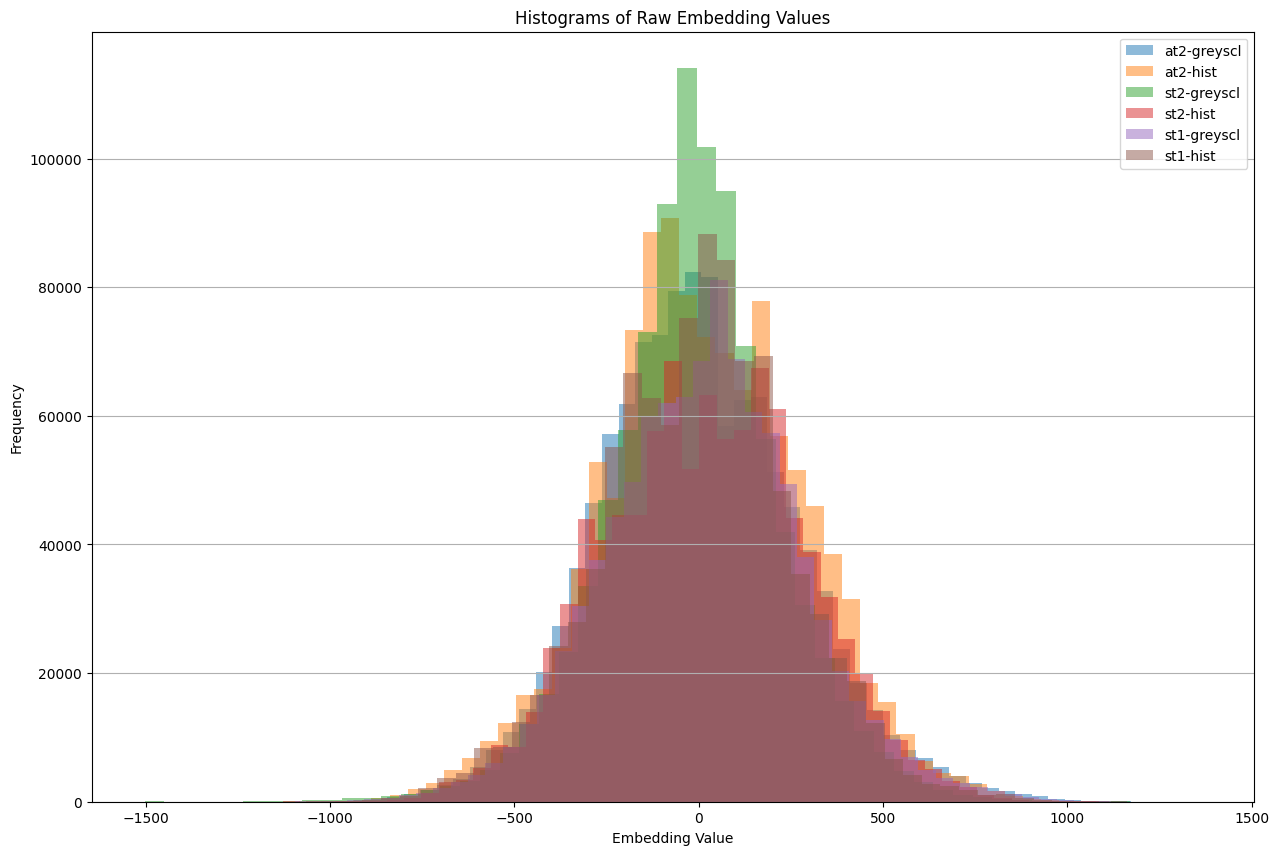

In [ ]:
file_paths = [
    '/kaggle/input/embeddings-for-rsna/at2-greyscl/final_embeddings.csv',
    '/kaggle/input/embeddings-for-rsna/at2-hist/final_embeddings.csv',
    '/kaggle/input/embeddings-for-rsna/st2-greyscl/final_embeddings.csv',
    '/kaggle/input/embeddings-for-rsna/st2-hist/final_embeddings.csv',
    '/kaggle/input/embeddings-for-rsna/st1-greyscl/final_embeddings.csv',
    '/kaggle/input/embeddings-for-rsna/st1-hist/final_embeddings.csv'
]

plt.figure(figsize=(15, 10))
for file_path in file_paths:
    df = pd.read_csv(file_path)

    embeddings = df.iloc[:, :512]

    flattened_embeddings = embeddings.values.flatten()

    legend_label = file_path.split('/')[-2]
    
    plt.hist(flattened_embeddings, bins=50, alpha=0.5, label=legend_label)

plt.title('Histograms of Raw Embedding Values')
plt.xlabel('Embedding Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()
